## task2：实现ARMA模型预测

### 引入数据集

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 引入数据集
dataset = pd.read_csv('exp1_data/daily-min-temperatures.csv', index_col=0, parse_dates=[0]) # 指定索引为Date，并处理为日期格式
dataset.head(11)

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8
1981-01-07,15.8
1981-01-08,17.4
1981-01-09,21.8


### 数据可视化

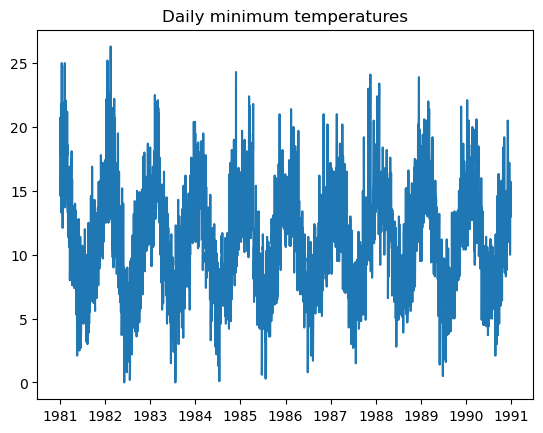

In [2]:
# 数据可视化
plt.plot(dataset.Temp)
plt.title('Daily minimum temperatures')
plt.show()

In [3]:
# 数据预处理，插值
dataset = dataset.resample('D').interpolate(method='linear')  # 重采样，按天取平均值

定义绘图函数

In [4]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 定义绘图函数，画出原信号、ACF、PACF图
def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # 指定轴
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf = plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # 绘制图像
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series Analysis Plots')
    plot_acf(xt, lags=nlag, ax=ax_acf)
    plot_pacf(xt, lags=nlag, ax=ax_pacf)
    plt.tight_layout()
    plt.show()
    return None

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


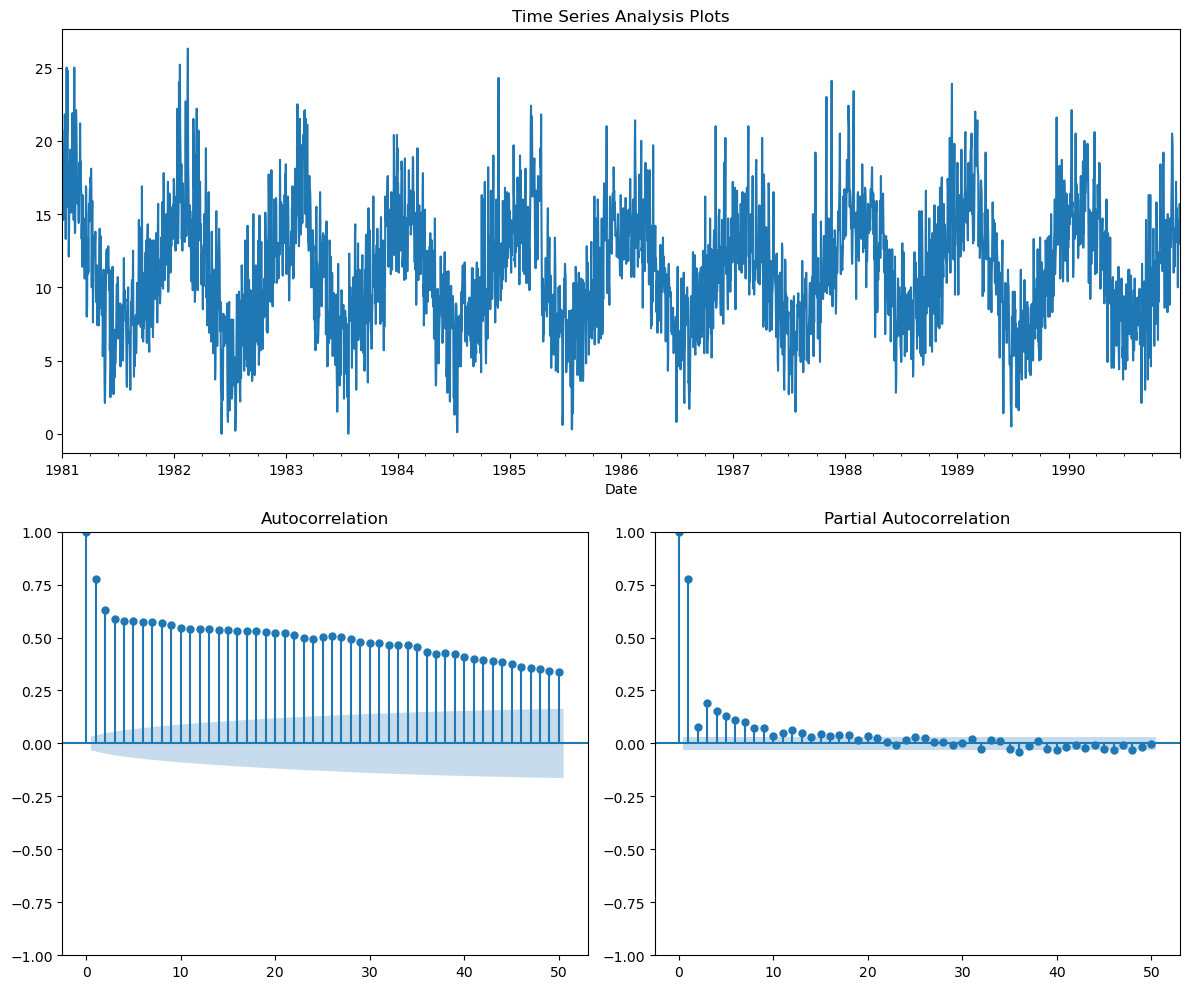

In [5]:
# 画出三图
plotds(dataset.Temp, nlag=50)

ADF检验序列是否平稳

In [6]:
from statsmodels.tsa.stattools import adfuller as ADF
diff = 0
# 采用单位根检验ADF检验时序是否平稳
def ADF_test(series):
    adf = ADF(series)
    if adf[1] > 0.05:
        print('序列是不平稳的,p为:', adf[1])
    else:
        print('序列是平稳的,p为:', adf[1])
        
ADF_test(dataset.Temp)

序列是平稳的,p为: 0.0002509067125120582


### 构建AR模型

模型的识别和定阶

In [13]:
from statsmodels.tsa.ar_model import AutoReg as AR

aicVal = []
for ari in range(0, 50):
    try:
        model = AR(dataset.Temp.tolist(), lags=ari).fit()
        aicVal.append([ari, model.aic])
    except Exception as e:
        print(e)
        
print(aicVal)
min_aic = min(aicVal, key=lambda x: x[1])
best_ari = min_aic[0]

print('Best AR order (ari):', best_ari)

[[0, 20621.79442183768], [1, 17262.668870812173], [2, 17239.176800526348], [3, 17102.23011024073], [4, 17013.62754346227], [5, 16949.64994130181], [6, 16903.100044900442], [7, 16862.967322648867], [8, 16841.460574096593], [9, 16816.185988188085], [10, 16809.27149838781], [11, 16798.18749415789], [12, 16781.3873095076], [13, 16770.31575146165], [14, 16761.150330910186], [15, 16745.223536322843], [16, 16739.1829295588], [17, 16730.05216335447], [18, 16715.643427308536], [19, 16710.135951382566], [20, 16702.47702689962], [21, 16697.504884977032], [22, 16688.277152077022], [23, 16686.433201162912], [24, 16683.73442121559], [25, 16678.541365485267], [26, 16673.303830376695], [27, 16671.14918422419], [28, 16669.28276001509], [29, 16667.40052186011], [30, 16665.54525776595], [31, 16662.56111544267], [32, 16658.436399511033], [33, 16654.616913586433], [34, 16649.696276527644], [35, 16646.010871281287], [36, 16637.749860588287], [37, 16635.515146198744], [38, 16632.609103056562], [39, 16627.844

利用AIC准则，选择AIC最小的阶数作为AR(p)的模型，即p=♾️

In [17]:
model = AR(dataset.Temp.tolist(), lags=999)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3652
Model:                   AutoReg(999)   Log Likelihood               -5475.654
Method:               Conditional MLE   S.D. of innovations              1.906
Date:                Mon, 16 Sep 2024   AIC                          12953.309
Time:                        10:42:26   BIC                          18842.639
Sample:                           999   HQIC                         15084.969
                                 3652                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0532      1.598      1.285      0.199      -1.079       5.186
y.L1           0.5336      0.019     27.486      0.000       0.496       0.572
y.L2          -0.0790      0.022     -3.589      0.0

模型预测

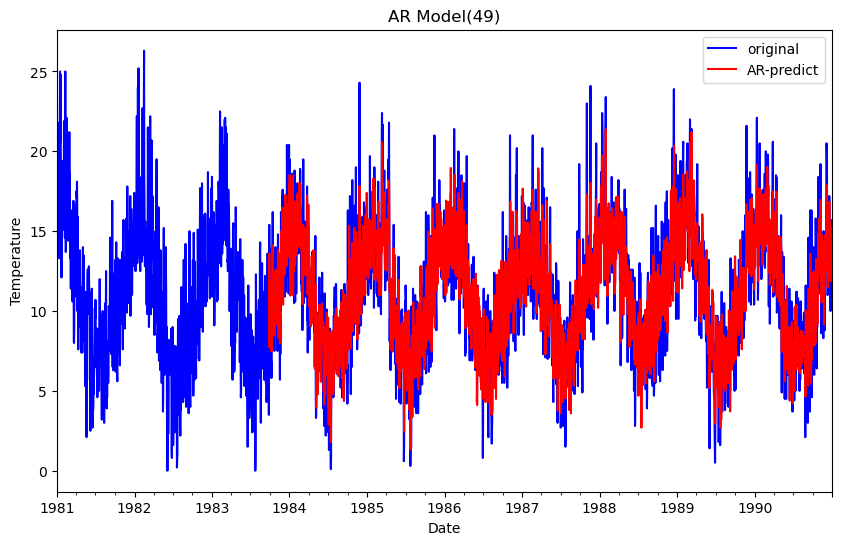

In [18]:
dataset['AR'] = model_fit.predict()
fig,ax = plt.subplots(1, sharex=True)
fig.set_size_inches(10, 6)

# 画出真实数据
dataset.Temp.plot(ax=ax, color='b', label='original')
# 画出预测数据
dataset.AR.plot(ax=ax, color='r', label='AR-predict')
ax.set_title('AR Model(%s)' % best_ari)

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

预测值与真实值对比

从图中可以看出，原始数据（蓝线）和由自回归模型（AR 模型）拟合得到的预测结果（红线）高度吻合。温度的时间序列展示了显著的季节性波动，拟合结果基本捕捉到了这种周期性趋势。

### 构建MA模型

In [10]:
from statsmodels.tsa.arima.model import ARIMA

aicVal = []
for ari in range(0, 10):
    try:
        model = ARIMA(dataset.Temp.tolist(), order=(0, 0, ari)).fit(method='innovations_mle')
        aicVal.append([ari, model.aic])
    except Exception as e:
        print(e)
        
print(aicVal)
min_aic = min(aicVal, key=lambda x: x[1])
best_ari = min_aic[0]

print('Best MA order (ari):', best_ari)

[[0, 20621.794421837676], [1, 18563.39962158988], [2, 17954.860235186814], [3, 17718.31010334193], [4, 17586.55060163574], [5, 17482.792173775168], [6, 17419.526523272216], [7, 17347.289116658583], [8, 17300.80328426769], [9, 17242.6143951451]]
Best MA order (ari): 9


利用AIC准则，发现MA(q)，中的q越大越好，因此选择AIC最小的阶数作为AR(p)的模型，即p=999

In [19]:
model = AR(dataset.Temp.tolist(), lags=999)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3652
Model:                   AutoReg(999)   Log Likelihood               -5475.654
Method:               Conditional MLE   S.D. of innovations              1.906
Date:                Mon, 16 Sep 2024   AIC                          12953.309
Time:                        10:46:56   BIC                          18842.639
Sample:                           999   HQIC                         15084.969
                                 3652                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0532      1.598      1.285      0.199      -1.079       5.186
y.L1           0.5336      0.019     27.486      0.000       0.496       0.572
y.L2          -0.0790      0.022     -3.589      0.0

模型预测

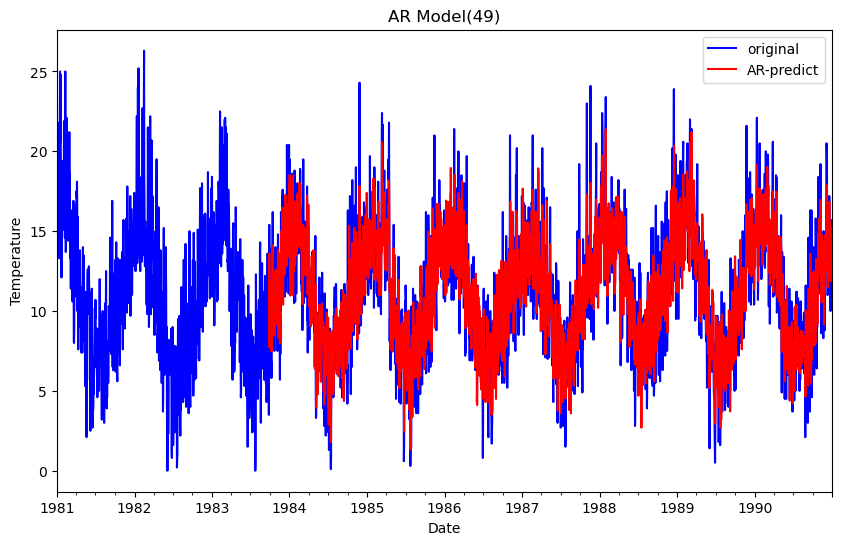

In [21]:
dataset['AR'] = model_fit.predict()
fig,ax = plt.subplots(1, sharex=True)
fig.set_size_inches(10, 6)

# 画出真实数据
dataset.Temp.plot(ax=ax, color='b', label='original')
# 画出预测数据
dataset.AR.plot(ax=ax, color='r', label='AR-predict')
ax.set_title('AR Model(%s)' % best_ari)

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

预测值与真实值对比

从图中可以看出，原始数据（蓝线）和由自回归模型（AR 模型）拟合得到的预测结果（红线）高度吻合。温度的时间序列展示了显著的季节性波动，拟合结果基本捕捉到了这种周期性趋势。

### 构建ARMA模型

模型的识别和定阶

根据ACF、PACF图可以发现均为拖尾的，因此我们采用ARMA模型，并想要进一步确定模型阶数

In [7]:
import statsmodels.tsa.api as smtsa

aicVal = []
for ari in range(0,3):
    for maj in range(0,3):
        try:
            arma_obj = smtsa.ARIMA(dataset.Temp.tolist(), order=(ari, 0, maj)).fit(method='innovations_mle')
            print(arma_obj.summary())
            aicVal.append([ari, maj, arma_obj.aic])
        except Exception as e:
            print(e)

print(aicVal)
min_aic = min(aicVal, key=lambda x: x[2])
best_ari = min_aic[0]
best_maj = min_aic[1]

print("Best AR order (ari): ", best_ari)
print("Best MA order (maj): ", best_maj)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3652
Model:                          ARIMA   Log Likelihood              -10308.897
Date:                Mon, 16 Sep 2024   AIC                          20621.794
Time:                        09:38:30   BIC                          20634.200
Sample:                             0   HQIC                         20626.212
                               - 3652                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1796      0.068    164.697      0.000      11.047      11.313
sigma2        16.5724      0.397     41.709      0.000      15.794      17.351
Ljung-Box (L1) (Q):                2191.84   Jarque-

利用AIC准则，选择AIC最小的阶数作为ARMA(p,q)的模型，即p=2,q=2

In [8]:
model = smtsa.ARIMA(dataset.Temp, order=(best_ari, 0, best_maj))
model_fit = model.fit()
print(model_fit.summary())

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 3652
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8387.982
Date:                Mon, 16 Sep 2024   AIC                          16787.963
Time:                        09:38:54   BIC                          16825.181
Sample:                    01-01-1981   HQIC                         16801.217
                         - 12-31-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4857      0.812     14.150      0.000       9.895      13.077
ar.L1          1.2370      0.040     30.803      0.000       1.158       1.316
ar.L2         -0.2426      0.040     -6.126      0.0

模型预测与拟合

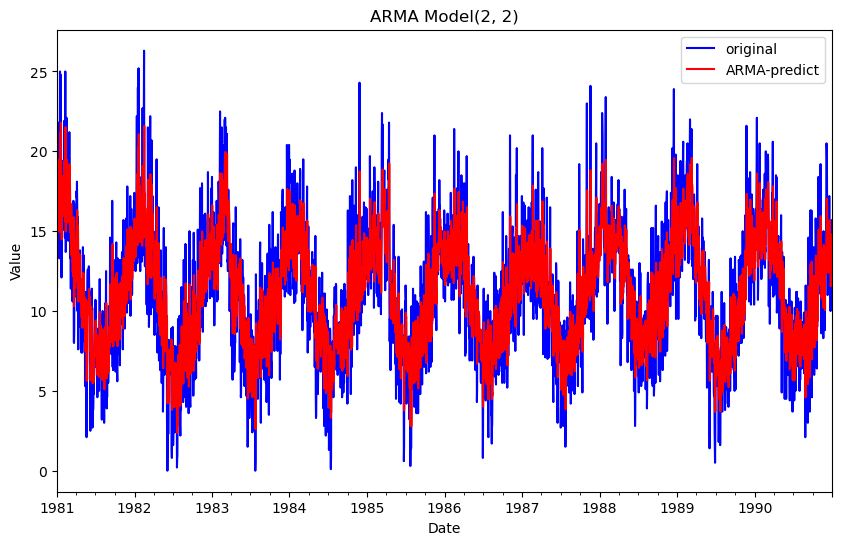

In [9]:
# 将拟合结果存储到data变量，列名命名为ARMA
dataset['ARMA'] = model_fit.predict(typ='levels',dynamic=False)
fig, ax = plt.subplots(1, sharex=True)
fig.set_size_inches(10, 6)

# 画出真实数据图像
dataset['Temp'].plot(ax=ax, label='original', color='blue')
# 画出拟合数据图像
dataset['ARMA'].plot(ax=ax, label='ARMA-predict', color='red')
ax.set_title('ARMA Model(%s, %s)' % (best_ari, best_maj))

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

预测值与真实值对比

从图中可以看出，原始数据（蓝线）和由自回归模型（AR 模型）拟合得到的预测结果（红线）高度吻合。温度的时间序列展示了显著的季节性波动，拟合结果基本捕捉到了这种周期性趋势。